# Histogrammar basic tutorial

Histogrammar is a Python package that allows you to make histograms from numpy arrays, and pandas and spark dataframes. (There is also a scala backend for Histogrammar.) 

This basic tutorial shows how to:
- make histograms with numpy arrays and pandas dataframes, 
- plot them, 
- make multi-dimensional histograms,
- the various histogram types,
- to make many histograms at ones,
- and store and retrieve them. 

Enjoy!

In [1]:
import pandas as pd
import histogrammar as hg
from histogrammar import resources

# open synthetic data
df = pd.read_csv(resources.data('test.csv.gz'), parse_dates=['date'])
df.head()

# create a histogram, tell it to look for column 'age'
hist = hg.Histogram(num=100, low=0, high=100, quantity='age')
# fill the histogram with column 'age'
hist.fill.numpy(df)
# and plot it
hist.plot.matplotlib()

# generate histograms of all features in the dataframe using automatic binning
# (importing histogrammar automatically adds this functionality to a pandas or spark dataframe)
hists = df.hg_make_histograms()
print(hists.keys())

# multi-dimensional histograms are also supported: longitude vs latitude
hists = df.hg_make_histograms(features=['longitude:latitude'])
ll = hists['longitude:latitude']
ll.plot.matplotlib()

# store histogram
ll.toJsonFile('longitude:latitude.json')
# and retrieve it again
factory = hg.Factory()
ll2 = factory.fromJsonFile('long_age.json')
ll2.plot.matplotlib()


AssertionError: 

<AxesSubplot:title={'center':'SparselyBin'}>

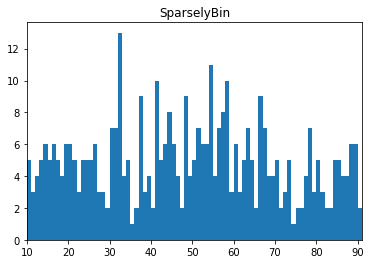

In [2]:
hist = hg.SparselyHistogram(binWidth=1, quantity='age')
# fill the histogram with column 'age'
hist.fill.numpy(df)
# and plot it
hist.plot.matplotlib()


In [8]:
# histogram selections. Here 'date' is the first axis of each histogram.
features=[
  'date:isActive', 'date:age', 'date:eyeColor', 'date:gender',
  'date:latitude', 'date:longitude', 'date:isActive:age'
]

# Specify your own binning specifications for individual features or combinations thereof.
# This bin specification uses open-ended ("sparse") histograms; unspecified features get
# auto-binned. The time-axis binning, when specified here, needs to be in nanoseconds.
bin_specs={
  'longitude': {'bin_width': 5.0, 'bin_offset': 0.0},
  'latitude': {'bin_width': 5.0, 'bin_offset': 0.0},
  'age': {'bin_width': 10.0, 'bin_offset': 0.0},
  'date': {'bin_width': pd.Timedelta('4w').value,
           'bin_offset': pd.Timestamp('2015-1-1').value}
}

# generate histograms with these bin specifications
hists = df.hg_make_histograms(features=features, bin_specs=bin_specs)


100%|████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 121.55it/s]


In [1]:
%%capture
# install histogrammar (if not installed yet)
import sys

!"{sys.executable}" -m pip install histogrammar

In [2]:
import histogrammar as hg

In [3]:
import pandas as pd
import numpy as np
import matplotlib

## Data generation
Let's first load some data!

In [4]:
# open a pandas dataframe for use below
from histogrammar import resources
df = pd.read_csv(resources.data("test.csv.gz"), parse_dates=["date"])

In [5]:
df.head()

,_id,address,age,balance,company,email,eyeColor,favoriteFruit,gender,guid,...,isActive,latitude,longitude,name,phone,registered,tags,transaction,currency,date
0,565ebe61ffa6f757b5029f29,"109 Monument Walk, Vicksburg, California, 6247",16,"$1,333.24",DOGSPA,tamekajoyce@dogspa.com,grey,banana,female,c06a96e4-31e2-426e-aa5a-51e3c71991aa,...,False,18.821230,-131.721235,Tameka Joyce,+1 (914) 553-2622,2015-05-02T07:39:52 -02:00,"['anim', 'eu', 'proident', 'duis', 'et', 'sit'...",1131.03,DOL,2015-05-02 07:39:52
1,565ebe616e073b23430d7052,"602 Harkness Avenue, Tyhee, Arizona, 5853",57,"$3,777.44",APPLICA,rosettaflynn@applica.com,brown,banana,female,6bbcaf11-a6b9-4f00-9db1-84fc11161526,...,True,-82.134610,52.720886,Rosetta Flynn,+1 (984) 525-3783,2015-06-16T08:08:53 -02:00,"['in', 'non', 'exercitation', 'dolor', 'aliqui...",-896.55,DOL,2015-06-16 08:08:53
2,565ebe6141fdb23a67dd7584,"286 Fay Court, Forbestown, Pennsylvania, 6141",26,"$1,248.97",HOMETOWN,kathiemurray@hometown.com,blue,strawberry,female,b85ef702-39f4-42dd-a87f-ce97864c3551,...,True,62.383017,-85.223346,Kathie Murray,+1 (859) 442-2358,2015-10-26T07:34:56 -01:00,"['culpa', 'sint', 'Lorem', 'culpa', 'veniam', ...",1224.04,DOL,2015-10-26 07:34:56
3,565ebe61c33636f6df907b06,"617 Baycliff Terrace, Castleton, Oklahoma, 7714",63,"$1,049.77",ISIS,bennetthahn@isis.com,green,strawberry,male,b42f1df9-839f-4f39-b3de-7ea3ac177786,...,True,-26.913326,-67.825793,Bennett Hahn,+1 (894) 564-2079,2015-06-04T01:59:25 -02:00,"['et', 'cillum', 'cillum', 'ad', 'laborum', 'c...",541.08,DOL,2015-06-04 01:59:25
4,565ebe61225511fd3288bb63,"262 Scholes Street, Fillmore, Utah, 2905",74,"$2,942.64",FUTURITY,cottoncarson@futurity.com,red,strawberry,male,14e518aa-2701-4397-94e7-72b9c27655ad,...,False,-2.777228,155.341981,Cotton Carson,+1 (825) 597-2328,2015-03-25T10:09:35 -01:00,"['labore', 'ea', 'officia', 'aliquip', 'nostru...",-372.62,DOL,2015-03-25 10:09:35


## Let's fill a histogram!

Histogrammar treats histograms as objects. You will see this has various advantages.

Let's fill a simple histogram with a numpy array.

In [6]:
# this creates a histogram with 100 even-sized bins in the (closed) range [-5, 5]
hist1 = hg.Bin(num=100, low=-5, high=5)

In [ ]:
# filling it with one data point:
hist1.fill(0.5)

In [ ]:
print (hist1.entries)

In [ ]:
# filling the histogram with an array:
hist1.fill.numpy(np.random.normal(size=10000))

In [ ]:
print (hist1.entries)

In [ ]:
# let's plot it
hist1.plot.matplotlib()

In [ ]:
# Alternatively, you can call this to make the same histogram:
# hist1 = hg.Histogram(num=100, low=-5, high=5)

Histogrammar also supports "sparse" historgrams, which are open-ended. Bins in a sparse histogram only get created and filled if the corresponding data points are encountered. 

A sparse histogram has a bin-width, and optionally a bin-origin parameter. Sparse histograms are nice if you don't want to restrict the range, for example for tracking data distributions over time, which may have large, sudden outliers.

In [ ]:
hist2 = hg.SparselyBin(binWidth=10)

In [ ]:
hist2.fill.numpy(df['age'].values)

In [ ]:
hist2.plot.matplotlib()

In [ ]:
# Alternatively, you can call this to make the same histogram:
# hist2 = hg.SparselyHistogram(binWidth=10)

## Filling from a dataframe

When importing histogrammar, pandas (and spark) dataframes get extra functions to create histograms that all start with "hg_". For example: hg_Bin or hg_SparselyBin.

Let's make the same 1d (sparse) histogram directly from a (pandas) dataframe.

In [ ]:
hist3 = df.hg_SparselyBin(binWidth=10, origin=0, quantity='age')
hist3.plot.matplotlib()

Note that the column "age" is picked by setting quantity="age". 

In [ ]:
# Alternatively, do:
hist3 = hg.SparselyBin(binWidth=10, quantity='age')
hist3.fill.numpy(df)
# ... and hist3 automatically picks up column age from the dataframe.

For any 1-dimensional histogram extract the bin entries, edges and centers as follows:

In [ ]:
print(hist3.bin_entries())

In [ ]:
print (hist3.bin_edges())

In [ ]:
print (hist3.bin_centers())

There are also: 
- IrregularlyBin histograms, with irregular bin edges, and 
- CentrallyBin histograms, where no bin edges are given but bin centers, and which is open-ended on both sides.

In [ ]:
hist4 = df.hg_CentrallyBin(centers=[15, 25, 35, 45, 55, 65, 75, 85, 95], quantity='age')
hist4.plot.matplotlib()

Note the slightly different plotting style for CentrallyBin histograms.

## Multi-dimensional histograms

Let's make a multi-dimensional histogram. In Histogrammar, a multi-dimensional histogram is composed as two recursive histograms. 

We will use histograms with irregular binning in this example.

In [ ]:
edges1 = [-100, -75, -50, -25, 0, 25, 50, 75, 100]
edges2 = [-200, -150, -100, -50, 0, 50, 100, 150, 200]

In [ ]:
hist1 = hg.IrregularlyBin(edges=edges1, quantity='latitude')
hist2 = hg.IrregularlyBin(edges=edges2, quantity='longitude', value=hist1)

# for 3 dimensions or higher simply add the 2-dim histogram to the value argument
hist3 = hg.SparselyBin(binWidth=10, quantity='age', value=hist2)

In [ ]:
hist2.fill.numpy(df)
hist2.plot.matplotlib()

In [ ]:
# number of dimensions per histogram
print (hist1.n_dim, hist2.n_dim, hist3.n_dim)

## Histogram types

So far we have covered the histogram types: 
- Bin histograms: with a fixed range and even-sized bins,
- SparselyBin histograms: open-ended and with a fixed bin-width,
- IrregularlyBin histograms: using irregular bin edges,
- CentrallyBin histograms: open-ended and using bin centers.

All of these process numeric variables only.

### Categorical variables

For categorical variables use the Categorize histogram
- Categorize histograms: accepting categorical variables such as strings and booleans.



In [ ]:
histy = hg.Categorize('eyeColor')
histx = hg.Categorize('favoriteFruit', value=histy)

In [ ]:
histx.fill.numpy(df)
histx.plot.matplotlib()

In [ ]:
# show the datatypy(s) of the histogram
print (histx.datatype)

Categorize histograms also accept booleans:

In [ ]:
histy = df.hg_Categorize('isActive')
histy.plot.matplotlib()

In [ ]:
print (histy.bin_entries())

In [ ]:
print (histy.bin_labels())
# histy.bin_centers() will work as well for Categorize histograms

### Other histogram types

There are several more histogram types:
- Minimize, Maximize: keep track of the min or max value of a numeric distribution,
- Average, Deviate: keep track of the mean or mean and standard deviation of a numeric distribution,
- Sum: keep track of the sum of a numeric distribution,
- Stack: keep track how many data points pass certain thresholds.
- Bag: works like a dict, it keeps tracks of all unique values encounterd in a column, and can also do this for vector s of numbers. For strings, Bag works just like the Categorize histogram.

In [ ]:
hmin = df.hg_Minimize('latitude')
hmax = df.hg_Maximize('longitude')
print (hmin.min, hmax.max)

In [ ]:
havg = df.hg_Average('latitude')
hdev = df.hg_Deviate('longitude')
print (havg.mean, hdev.mean, hdev.variance)

In [ ]:
hsum = df.hg_Sum('age')
print (hsum.sum)

In [ ]:
# let's illustrate the Stack histogram with longitude distribution
# first we plot the regular distribution
hl = df.hg_SparselyBin(25, 'longitude')
hl.plot.matplotlib()

In [ ]:
# Stack counts how often data points are greater or equal to the provided thresholds 
thresholds = [-200, -150, -100, -50, 0, 50, 100, 150, 200]

In [ ]:
hs = df.hg_Stack(thresholds=thresholds, quantity='longitude')
print (hs.thresholds)
print (hs.bin_entries())

Stack histograms are useful to make efficiency curves.

With all these histograms you can make multi-dimensional histograms. For example, you can evaluate the mean and standard deviation of one feature as a function of bins of another feature. (A "profile" plot, similar to a box plot.) 

In [ ]:
hav = hg.Deviate('age')
hlo = hg.SparselyBin(25, 'longitude', value=hav)
hlo.fill.numpy(df)

In [ ]:
hlo.bins

In [ ]:
hlo.plot.matplotlib()

### Convenience functions

There are several convenience functions to make such composed histograms. These are:
- Profile: Convenience function for creating binwise averages.
- SparselyProfile: Convenience function for creating sparsely binned binwise averages.
- ProfileErr: Convenience function for creating binwise averages and variances.
- SparselyProfile: Convenience function for creating sparsely binned binwise averages and variances.
- TwoDimensionallyHistogram: Convenience function for creating a conventional, two-dimensional histogram.
- TwoDimensionallySparselyHistogram: Convenience function for creating a sparsely binned, two-dimensional histogram.

In [ ]:
# For example, call this convience function to make the same histogram as above:
hlo = df.hg_SparselyProfileErr(25, 'longitude', 'age')
hlo.plot.matplotlib()

## Making many histograms at once

There a nice method to make many histograms in one go. See here.

By default automagical binning is applied to make the histograms.

More details one how to use this function are found in in the advanced tutorial.

In [ ]:
hists = df.hg_make_histograms()

In [ ]:
print (hists.keys())

In [ ]:
h = hists['transaction']
h.plot.matplotlib()

In [ ]:
h = hists['date']
h.plot.matplotlib()

In [ ]:
# you can also select which and make multi-dimensional histograms
hists = df.hg_make_histograms(features = ['longitude:age'])

In [ ]:
hist = hists['longitude:age']
hist.plot.matplotlib()

## Storage

Histograms can be easily stored and retrieved in/from the json format.

In [ ]:
# storage
hist.toJsonFile('long_age.json')

In [ ]:
# retrieval
factory = hg.Factory()
hist2 = factory.fromJsonFile('long_age.json')
hist2.plot.matplotlib()

In [ ]:
# to store many histograms at once:

In [ ]:
%%script false --no-raise-error

# we can store the histograms if we want to
import json
from histogrammar.util import dumper

# store
with open('histograms.json', 'w') as outfile:
	json.dump(hists, outfile, default=dumper)

# and load again
with open('histograms.json') as handle:
	hists2 = json.load(handle)

In [ ]:
print(hists.keys())

## Advanced tutorial

The advanced tutotial shows:
- How to work with spark dataframes.
- More details on this nice method to make many histograms in one go. For example how to set bin specifications.
